In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.random import exponential
import random
import pandas as pd

# To get smooth ani|mations
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '\\Users\\lukep\\ffmpeg\\ffmpeg-20200206-343ccfc-win64-static\\bin\\'
import matplotlib.animation as animation
import matplotlib as mpl
import ffmpeg
mpl.rc('animation', html='jshtml')


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.environments.wrappers import ActionRepeat
from tf_agents.environments import batched_py_environment
from tf_agents.environments import parallel_py_environment

from collections import deque

# Disable GPU FOR NOW


In [2]:
BOARD_SIZE = 8
MAX_HEALTH = 20

Test code for Snake Environment

In [3]:
class Snake():
    
    # Initialize
    def __init__(self, BOARD_SIZE, MAX_HEALTH):  
        # Set Initial Position
        self.path_X = deque()
        self.path_X.append(np.random.randint(low=2, high=BOARD_SIZE-2))
        self.path_X.append(self.path_X[0])
        self.path_X.append(self.path_X[0])
        self.path_Y = deque()
        self.path_Y.append(np.random.randint(low=2, high=BOARD_SIZE-2))
        self.path_Y.append(self.path_Y[0]+1)
        self.path_Y.append(self.path_Y[0]+2)
        
        # Set Initial Health
        self.max_health = MAX_HEALTH
        self.health = MAX_HEALTH
        
        # Set if snake has just eaten
        self.just_eaten = False
    
    # Return all coordinates
    def get_path_coords(self):
        return self.path_X, self.path_Y
    
    def get_head_coords(self):
        return self.path_X[0], self.path_Y[0]
    
    def get_neck_coords(self):
        return self.path_X[1], self.path_Y[1]
    
    def get_tail_coords(self):
        return self.path_X[-1], self.path_Y[-1]
    
    # Return health
    def reduce_health(self):
        self.health-=1
    
    def get_health(self):
        return self.health
    
    def set_full_health(self):
        self.health = self.max_health
        
    def get_just_eaten(self):
        return self.just_eaten
    
    def set_just_eaten(self, boolean):
        self.just_eaten = boolean
    
    def move(self, action):
        i=0; j=0
        if (action==0):
            i = 1
        elif (action==1):
            j = 1
        elif (action==2):
            i = -1
        elif (action==3):
            j = -1
        else:
            raise ValueError('`action` should be 0 or 1 or 2 or 3.')
        self.path_X.appendleft(self.path_X[0]+i)
        self.path_Y.appendleft(self.path_Y[0]+j)
        if not self.just_eaten:
            self.path_X.pop()
            self.path_Y.pop()

In [4]:
class SnakeEnv(py_environment.PyEnvironment):
    
    def reset_board(self):
        
        # Create Snakes
        self.master_snake = Snake(BOARD_SIZE, MAX_HEALTH)
        
        # Create Board
        self._state = [([[0, 0, 0]]*BOARD_SIZE) for i in range(BOARD_SIZE)]
        self._episode_ended = False 
        master_x_coords, master_y_coords = self.master_snake.get_path_coords()
        for i, (x, y) in enumerate(zip(master_x_coords, master_y_coords)):
                if i == 0:
                    self._state[y][x] = [0, 1, 0]
                else:
                    self._state[y][x] = [1, 0, 0]
    
        # Set food timer
        self.food_spawn_arr = np.ceil(exponential(5, size=100))
        self.current_food_spawn = 0 #current index of above array
        self.food_timer = 0
        # Maybe store other snakes healths in an array?

        # Set if snake ate during previous turn
        self.just_eaten = False
    
    def __init__(self, FOOD_REWARD, STEP_REWARD):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(BOARD_SIZE,BOARD_SIZE, 3), dtype=np.int32, minimum=-1, name='observation')
        self.reset_board()
        self.FOOD_REWARD = FOOD_REWARD
        self.STEP_REWARD = STEP_REWARD
        
    def action_spec(self):
        return self._action_spec
    
    def get_board(self):
        return np.abs(self._state)

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.reset_board()
        return ts.restart(np.array(self._state, dtype=np.int32))
            
        
    def foodspawn_assist(self):
        coords = np.argwhere(np.all(np.array(self._state) == [0, 0, 0], axis=-1))
        coord = random.choice(coords)
        self._state[coord[0]][coord[1]] = [0, 0, 1]
        return None

    def _step(self, action):
        
        reward = 0
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        
        # Reduce Health
        self.master_snake.reduce_health()
        
        # Get Previous tail coordinates
        master_tail_x, master_tail_y = self.master_snake.get_tail_coords()
        
        # Apply Action
        try: self.master_snake.move(action)
        except ValueError as error:
            raise ValueError('`action` should be 0 or 1 or 2 or 3.')
        
        # Get  New Head Coords
        master_head_x, master_head_y = self.master_snake.get_head_coords()
        master_neck_x, master_neck_y = self.master_snake.get_neck_coords()
        
        # Spawn Food
        self.food_timer +=1
        if (self.food_spawn_arr[self.current_food_spawn]==self.food_timer):
            # Spawn Food
            self.foodspawn_assist()
            # Reset Timer
            self.food_timer = 0
            self.current_food_spawn = (self.current_food_spawn+1)%len(self.food_spawn_arr)
        
        # Check to see if out of bounds or hit itself
        if (master_head_x == BOARD_SIZE or master_head_y == BOARD_SIZE \
            or master_head_x == -1 or master_head_y == -1 \
            or self._state[master_head_y][master_head_x] == [1, 0, 0]):
            self._episode_ended = True
        
        # Else perform snake step
        else:
            # Check What block snake has landed on. If -1 then
            # it landed on food
            block = self._state[master_head_y][master_head_x]

            # Set Head Value to 2
            self._state[master_head_y][master_head_x] = [0,1,0]
            # Set Neck to 1
            self._state[master_neck_y][master_neck_x] = [1,0,0]
            # If snake has not just eaten then set tail location to zero
            if not(self.master_snake.get_just_eaten()):
                self._state[master_tail_y][master_tail_x] = [0,0,0]
            self.master_snake.set_just_eaten(False)

            # Check if snake consumed food
            if(block==[0,0,1]):
                self.master_snake.set_full_health()
                self.master_snake.set_just_eaten(True)
                reward += self.FOOD_REWARD

        # If out of health then die
        if self.master_snake.get_health() == 0:
            self._episode_ended = True
        
        # If Episode Ended
        if self._episode_ended:
            reward = 0
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            reward += self.STEP_REWARD
            return ts.transition(
            np.array(self._state, dtype=np.int32), reward=reward, discount=1.0) 

# Testing

In [5]:
environment = SnakeEnv()
utils.validate_py_environment(environment, episodes=5)

In [6]:
env = SnakeEnv()

# Later Stuff

In [7]:
tf_env = tf_py_environment.TFPyEnvironment(env)

In [8]:
tf_env.observation_spec()

BoundedTensorSpec(shape=(8, 8, 3), dtype=tf.int32, name='observation', minimum=array(-1), maximum=array(2147483647))

# Train Network

In [9]:
max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames

## Training Architecture

For more details see 649-650. For now we need to create
1. A deep Q-Network
2. DQN Agent (takes care of creating the collect policy from replay buffer)
3. Replay buffer (and observer to write to it)
4. Some training metrics
5. The driver
6. The data set

### Deep-Q Network and DQN Agent

Heres the network. It has a preprocessing layer that normalizes all the entries. Next we apply a convolutional neural netork (chap 14). Lastly, it applies a dense layer with 512 inputs, and then automatically a dense layer with 4 outputs (one for each Q value). All these layers use ReLU activation functions (except the last one which has no activation function).

In [10]:
from tf_agents.networks.q_network import QNetwork
from tensorflow.keras.layers import Reshape

# Need to expand dimensions to channel layer
preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 2.)
conv_layer_params=[(16, (4, 4), 2), (32, (3 ,3), 1)]
fc_layer_params=[50, 50] 

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params,
    batch_squash=False)

Heres the agent. 

In [11]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# Create variable that counts the number of training steps
train_step = tf.Variable(0)
# Create optimizer 
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
# Computes epsilon for epsilon greedy policy given the training step
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=100000, 
    end_learning_rate=0.01) # final ε

agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.97, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

### Replay Buffer and Observer

TF-Agents provides some replay buffer implementation in the tf_agents.replay_buffers package.

In [12]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    # Determines the data spec type
    data_spec=agent.collect_data_spec,
    # The number of trajectories added at each step
    batch_size=tf_env.batch_size,
    # This can store 5 million trajectories (note: requires a lot of RAM)
    max_length=10000000)

# Create the observer that adds trajectories to the replay buffer
replay_buffer_observer = replay_buffer.add_batch

This class increments every time it is called

In [13]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

### Training Metrics

These training metrics can be stored during training (useful for outputting verbose things during training).

In [14]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

The metrics can be logged as follows:

In [15]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


### Collect Driver

The driver explores the environment using a given policy, collects experiences, and broadcasts them to some observers (and then the observers typically place them in the replay buffer).
1. Driver passes current **time step** to collect policy which then chooses an action and returns an **action step** object containing the action
2. The driver passes the action to the environment, which then returns the next step
3. The driver creates a trajectory object to represent this transition and broadcasts it to the observer

There are two main types of drivers:
1. DynamicStepDriver: Collects experiences for certain number of steps
2. DynamicEpisodeDriver: Collects experiences for certain number of episodes

In our case we want to for four steps for each training iteration (4 steps allows us to see where ball is going). We create it as follows:

In [16]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env, # Env to play with
    agent.collect_policy, # Collect policy of the agent
    observers=[replay_buffer_observer] + train_metrics, # pass to all observers
    num_steps=1) 

### Initializing the Replay Buffer with Experiences

In [17]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) 
final_time_step, final_policy_state = init_driver.run()

20000/20000

### Creating the Dataset

This has to do with sampling batches of trajectories from the replay buffer. To sample them, you just need to call the "get_next()" method. This also returns a BufferInfo object that contains the sample identifiers and their sampling probabilities.
* The following code samples a small batch of two trajectories (subepisodes) each containing three consecutive steps.

In [18]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

Can get all attributes of these trajectories

In [19]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

Shape of observations:

In [20]:
trajectories.observation.shape

TensorShape([2, 3, 8, 8, 3])

Two trajectories, each with three steps, each steps observation is 8x8. Can also convert  to time_steps, action_steps, and next_time_steps

In [21]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 8, 8, 3])

Now lets convert the dataset to a tensorflow dataset so we can take advantage of parallelization. We sample batches of 64 trajectories, each trajectory with 2 steps. The data set processes three elements in parallel, and prefetches 3 batches during training.

In [22]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

### Creating Training Loop

To speed up training we convert main functions to TensorFlow Fucntions. For this we use a wrapper

In [23]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

Heres a function that runs training for $n$ iterations

In [24]:
training_info = [[], [], [], []]

def add_metrics(arr, train_metrics):
    arr[0].append(train_metrics[0].result().numpy())
    arr[1].append(train_metrics[1].result().numpy())
    arr[2].append(train_metrics[2].result().numpy())
    arr[3].append(train_metrics[3].result().numpy())

In [25]:
def train_agent(n_iterations):
    time_step = None
    # Get initial policy state
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    # Create iterator over dataset and loop
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        # Pass current time step and policy state to get next time step and policy state
        # Collects experience for 4 steps then broadcasts trajectories to replay buffer
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        # Sample a batch of trajectories from the dataset, pass to the train method
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 5000 == 0:
            add_metrics(training_info, train_metrics)

Train the agent!

In [26]:
train_agent(n_iterations=10000000)

9999999 loss:0.01856

In [27]:
import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay

def get_vid_frames(policy, filename, num_episodes=20, fps=2):
    frames = []
    for _ in range(num_episodes):
        time_step = tf_env.reset()
        frames.append(np.abs(env.get_board())*100)
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = tf_env.step(action_step.action)
            frames.append(np.abs(env.get_board())*100)
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0], vmin=0, vmax=200)
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

frames = get_vid_frames(agent.policy, "trained-agent")

In [28]:
plot_animation(frames)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [29]:
df = pd.DataFrame(np.array(training_info).T, columns=['N_Ep', 'Env_Steps', 'Avf_RM', 'Avg_EPLM'])

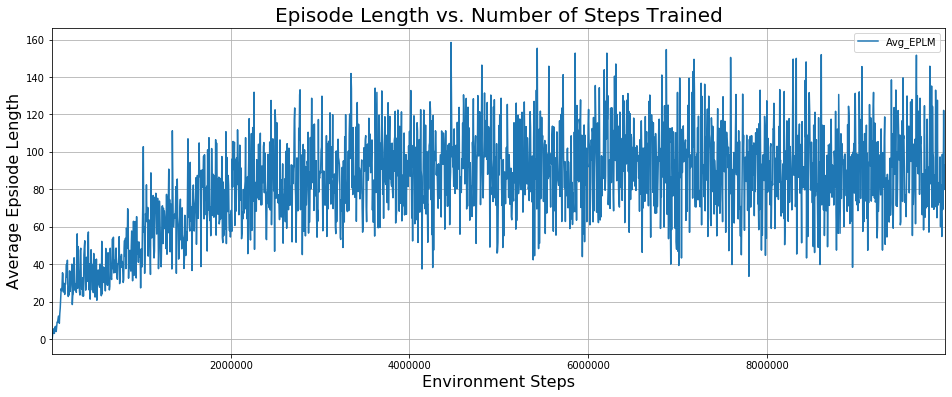

In [30]:
df.plot('Env_Steps', 'Avg_EPLM', figsize=(16,6))
plt.xlabel('Environment Steps', fontsize=16)
plt.ylabel('Average Epsiode Length', fontsize=16)
plt.title('Episode Length vs. Number of Steps Trained', fontsize=20)
plt.grid()
plt.show()